In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# To get the groups, run 
```python
import netCDF4
fp='ATL15_AA_0311_01km_001_01.nc'
nc = netCDF4.Dataset(fp)
nc
```

In [2]:
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')
ds

<xarray.Dataset>
Dimensions:              (time: 12, x: 5521, y: 4521)
Coordinates:
  * x                    (x) float64 -2.72e+06 -2.719e+06 ... 2.799e+06 2.8e+06
  * y                    (y) float64 -2.2e+06 -2.199e+06 ... 2.319e+06 2.32e+06
  * time                 (time) datetime64[ns] 2018-10-01T22:30:00 ... 2021-07-02T09:00:00
Data variables:
    Polar_Stereographic  int8 ...
    cell_area            (y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes:
    description:  delta_h group includes variables describing height differen...

In [3]:
for j in range(0, len(ds['time']) - 1):
    dt = ds['time'][j+1] - ds['time'][j]
    print(float(dt.values) * 1.15741e-14) # Print delta t in days

91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454
91.31270454


In [4]:
indf = 3
ind0 = 2
dh = ds['delta_h'][indf,:,:] - ds['delta_h'][ind0,:,:]
grounded_mask = np.load("grounded-mask/grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])
dh = dh * grounded_mask

In [5]:
# # Alpine3D region
# x_min = -1540e3
# x_max = -1380e3
# y_min = -110e3
# y_max = 0

# Coastal West Antarctica
x_min = -2000e3
x_max = -1200e3
y_min = -800e3
y_max = 250e3

x1_ind = (ds['x'] > x_min)
x2_ind = (ds['x'] < x_max)
x_ind = np.logical_and(x1_ind, x2_ind)

y1_ind = (ds['y'] > y_min)
y2_ind = (ds['y'] < y_max)
y_ind = np.logical_and(y1_ind, y2_ind)
dh_zone = dh[y_ind, x_ind]

# Save lat/lon array

In [6]:
# Get source x and y
src_x = dh_zone['x']
src_y = dh_zone['y']

# Create meshgrid then squash to a vector
src_x, src_y = np.meshgrid(src_x, src_y)
src_x = src_x.flatten()
src_y = src_y.flatten()

# Convert x and y vector to lat/lon vector
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # South Polar Stereo
tgt.ImportFromEPSG(4326) # WGS 84

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
tgt_lon = np.zeros(len(src_x)); tgt_lon[:] = np.nan
tgt_lat = np.zeros(len(src_x)); tgt_lat[:] = np.nan

# Perform transformation
for j in range(0, len(tgt_lon)):
    coords = transform.TransformPoint(src_x[j], src_y[j])
    tgt_lat[j], tgt_lon[j] = coords[0:2]
    
# Compile into array and save
lat_lon = np.transpose(np.stack([tgt_lat, tgt_lon]))
print(lat_lon.shape)

# Save array
np.savetxt("IC2_lat_lon.txt", lat_lon)

(838151, 2)


# Open inference array and format for visualization

In [7]:
inference = np.loadtxt("Inference_Y.txt")
inference = np.reshape(inference, dh_zone.shape)
inference = xr.DataArray(data=inference, dims=["y", "x"], coords=[dh_zone['y'], dh_zone['x']])
inference = inference * grounded_mask
dh_corr = dh_zone - inference

# Visualize change in surface height and change in FAC

2019-07-02T21:00:00.000000000
2019-04-02T13:30:00.000000000

-17.94942793091041
0.07347773095056837
0.062295962


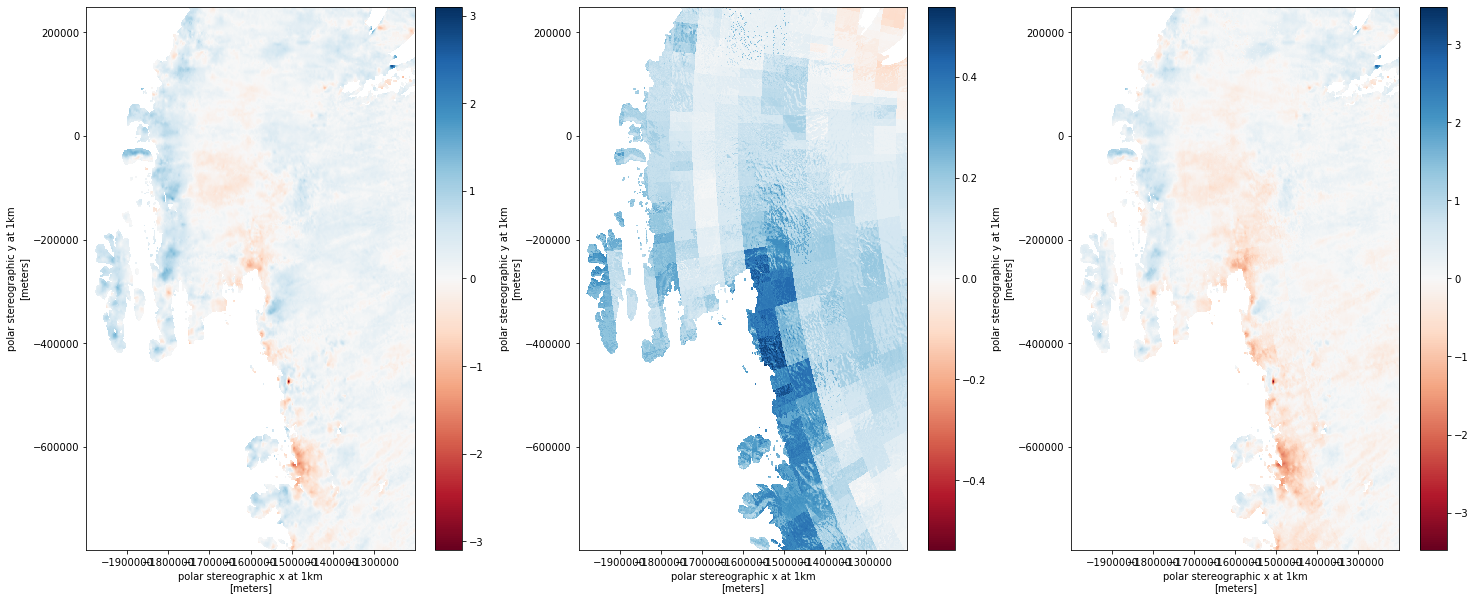

In [8]:
# Plot
fig, axes = plt.subplots(ncols=3, figsize=(25, 10))
dh_zone.plot(cmap=plt.cm.RdBu, ax=axes[0])
inference.plot(cmap=plt.cm.RdBu, ax=axes[1])
dh_corr.plot(cmap=plt.cm.RdBu, ax=axes[2])

# Print initial and final date
print(ds['time'][indf].values)
print(ds['time'][ind0].values)

# Calculate variance reduction
vr = 1 - (dh_corr.var() / dh_zone.var())
print()
print(100*vr.values)
print(dh_corr.var().values)
print(dh_zone.var().values)